In [1]:
from loadTDMS import *
from fft_test import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

In [2]:
# date = 20211025
# date = 20211115
# date = 20220630
# date = 20221027
# date = 20230113
# date = 20230117
date = "20230113+0117"
# date = 20230120
# date = 20230123

- 20230120
  d[0][36000*3:]　/ 1200回転
- 20230123
  d[0][1000000*3:] / 1023回転

In [118]:
dt = 1/10**6
split_t_r = 0.1 # 1つの枠で全体のどの割合のデータを分析するか。
overlap = 0.5  # オーバーラップ率
window_F = "hamming"  # 窓関数選択: hanning, hamming, blackman
y_label = "amplitude"
y_unit = "V"

In [46]:
def get_tdms(num):
    load_path = rf"Z:\100 Raw_data\{date}---切削実験\AE\Cutting\AE_{num}.tdms"
    d = load_tdms(load_path, ch_num=3)
    return d[0]
#     return d[0][36000*3:]
#     return d[0][1000000*3:]

In [21]:
for i in tqdm(range(1,461)):
    d = get_tdms(i)
    mensekis = []
    
    for j in range(0,1023):
        sample_num = 2**14
        start = j * 25000
        end = start + sample_num

        ds = d[start:end]
        
        N = len(ds)
        fq = np.linspace(0, N*dt, N)  # 周波数軸　linspace(開始,終了,分割数)
        
        fq_, amp_ = FFT_main(fq, ds, dt, split_t_r, overlap, window_F)
        amp_ = np.array(np.split(20*np.log10(amp_) +100, 10))

        menseki = np.sum(amp_, axis=1)
        mensekis.append(menseki)
    np.save(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\work\{i}", np.array(mensekis))

  0%|          | 0/460 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'Z:\\100 Raw_data\\20230117---切削実験\\AE\\Cutting\\AE_1.tdms'

In [3]:
date

'20230113+0117'

In [4]:
for i in tqdm(range(0,10)):
    d1 = np.load(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\work\1.npy")
    d1 = d1.T
    dd = d1[i]
#     print(dd.shape)
    for num in range(2,461):
        d2 = np.load(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\work\{num}.npy")
        d2 = d2.T
        dd = np.concatenate([dd,d2[i]])
#         print(dd.shape)
    start = i * 50
    end = (i+1) *50
    dd = dd.reshape(int(len(dd)/1200),1200)
#     print(dd.shape)
    np.save(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\work\All{i+1}",dd)

100%|██████████| 10/10 [00:19<00:00,  1.93s/it]


## NO outlier （外れ値除去）

In [99]:
%matplotlib qt
num = 2
norm = np.load(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\work\All{num+1}Norm_flatten.npy")
plt.plot(norm)

In [100]:
norm_n = np.where(norm < 0.04, 2, norm)
index = np.where(norm_n == 2)
d = np.load(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\work\All{num+1}.npy")
d = d.ravel()
d_o = d.copy()
index = index[0]
print(index)
print(d[index])
d[index] = np.average(d)
print(len(index))
plt.plot(d_o)
plt.plot(d)

[ 20400  93600 139200 270000 333600 433218 433219 433221 433223 433226
 433248 433265 433292 433295 433301 433302 433323 433328 433377 470400]
[1481.39556343 1474.95647879 1459.47728944 1479.01558962 1420.39700927
 1481.43873486 1457.33820677 1470.2846826  1482.13404407 1464.00441473
 1465.06301551 1472.65309827 1484.90054799 1474.05614605 1470.15514518
 1466.24309846 1479.67168648 1481.59224491 1465.28659854 1484.62085636]
20


In [101]:
d = d.reshape(int(len(d)/1200),1200)
np.save(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\work\NOoutlier\All{num+1}_NOoutlier",d)

## NOoutlierで正規化してヒートマップ等再作成

In [120]:
date

20230123

In [5]:
from sklearn import preprocessing

In [6]:
d_min = []
d_max = []
spectrum = []
d_std = []

for i in range(0,10):
    start = i * 50
    end = (i+1) *50

    d = np.load(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\work\All{i+1}.npy")
    d = d.T
    d = d.ravel()
    
    d_min.append(np.min(d))
    d_max.append(np.max(d))
    spectrum.append(f"{start}-{end}")
    
    d = preprocessing.minmax_scale(d)
    d_std.append(np.std(d))

d_min = np.array(d_min)
d_max = np.array(d_max)
d_minmax_diff = d_max - d_min


dict1 = dict(spectrum = spectrum[:] ,min_ = d_min[:], max_ = d_max[:], diff_ = d_minmax_diff[:], d_std = d_std[:])
df1 = pd.DataFrame(data=dict1)
df1.to_csv(rf'Z:\200 Produced_data\{date}\AE\menseki\50khz\work\EachSpectrumMinMax.csv')

In [7]:
df = pd.read_csv(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\work\EachSpectrumMinMax.csv")
df

,Unnamed: 0,spectrum,min_,max_,diff_,d_std
0,0,0-50,2044.577610,3783.274624,1738.697014,0.196681
1,1,50-100,1623.520085,3012.215742,1388.695656,0.130775
2,2,100-150,1395.939213,2762.182827,1366.243614,0.129726
3,3,150-200,1481.691971,2734.574811,1252.882840,0.230038
4,4,200-250,1529.744240,3125.937698,1596.193457,0.268233
5,5,250-300,1506.366095,3011.921424,1505.555328,0.260493
6,6,300-350,1474.902274,3029.313924,1554.411650,0.230603
7,7,350-400,1461.288182,2430.046910,968.758727,0.181011
8,8,400-450,1457.253563,2341.898163,884.644600,0.147753
9,9,450-500,1360.201173,2377.346723,1017.145549,0.124960


  0%|          | 0/10 [00:00<?, ?it/s]

460


 10%|█         | 1/10 [00:02<00:18,  2.02s/it]

460


 20%|██        | 2/10 [00:04<00:16,  2.06s/it]

460


 30%|███       | 3/10 [00:06<00:14,  2.05s/it]

460


 40%|████      | 4/10 [00:08<00:11,  2.00s/it]

460


 50%|█████     | 5/10 [00:09<00:09,  1.91s/it]

460


 60%|██████    | 6/10 [00:11<00:07,  1.88s/it]

460


 70%|███████   | 7/10 [00:13<00:05,  1.87s/it]

460


 80%|████████  | 8/10 [00:15<00:03,  1.87s/it]

460


 90%|█████████ | 9/10 [00:17<00:01,  1.87s/it]

460


100%|██████████| 10/10 [00:19<00:00,  1.91s/it]


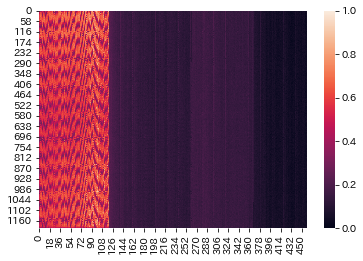

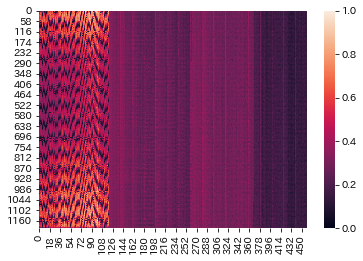

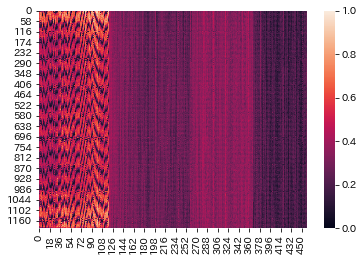

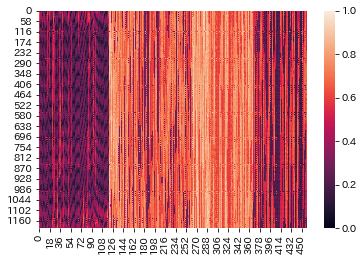

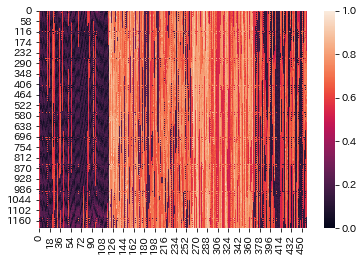

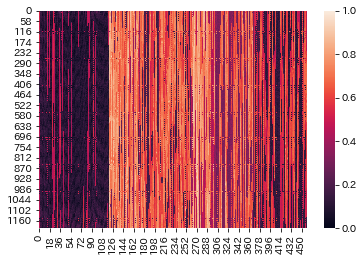

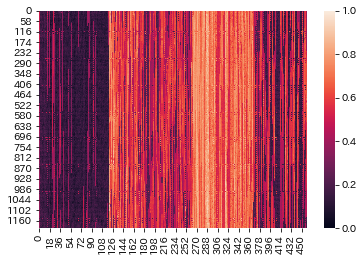

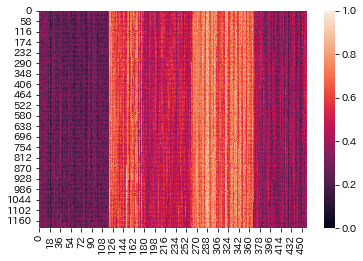

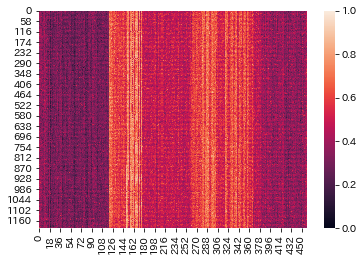

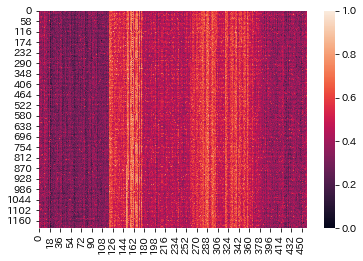

In [8]:
%matplotlib inline
for i in tqdm(range(0,10)):
    figure, ax = plt.subplots()
    d = np.load(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\work\All{i+1}.npy")
    d = d.ravel()
#     print(int(len(d)/1200))
    d = preprocessing.minmax_scale(d)
    np.save(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\work\All{i+1}Norm_flatten",d)
    d = d.reshape(460, int(len(d)/460))
    np.save(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\work\All{i+1}_Norm",d)
    sns.heatmap(d.T)
    figure.savefig(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\work\All{i+1}_Norm.png", dpi=500)

In [9]:
#all_path_num
a_p_n = 460
#all_rotation_num
a_r_n = 1200
#moving avg path step
m_a_p_s = 10

w_size = a_r_n*m_a_p_s
x = np.linspace(-1,1,w_size)
v = np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)
v = v / np.sum(v)
v = np.sort(v)[::-1]

In [127]:
# date = 20230123

In [10]:
for num in tqdm(range(0,10)):
    ae = np.load(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\work\All{num+1}Norm_flatten.npy")
    aem = np.convolve(ae,v, mode='valid')
    np.save(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\work\All{num+1}Norm_flatten_MA",aem)

100%|██████████| 10/10 [04:17<00:00, 25.74s/it]


In [129]:
cfm = np.load(rf"Z:\200 Produced_data\{date}\CF\max8308\All_delete_drift_MA.npy")

100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


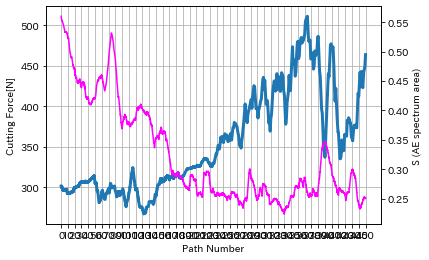

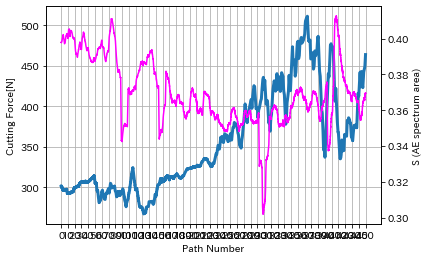

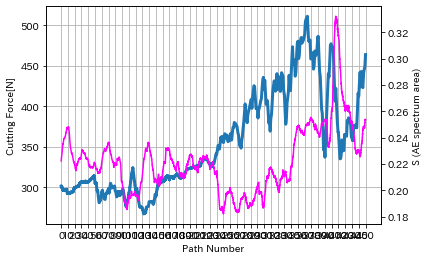

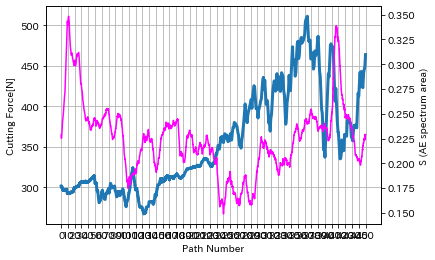

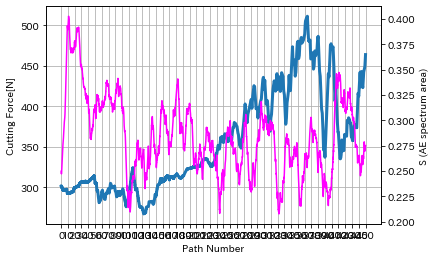

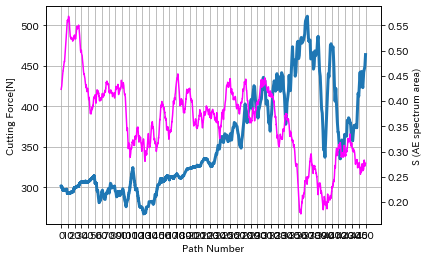

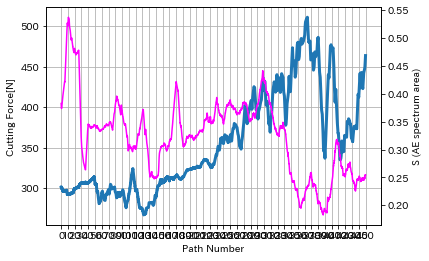

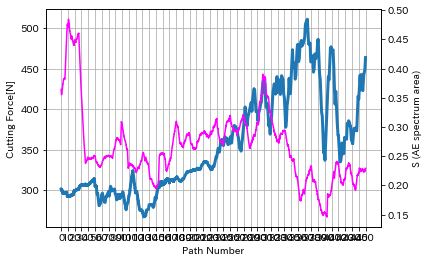

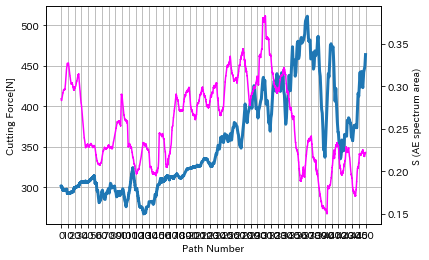

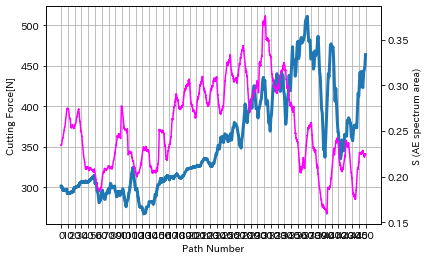

In [130]:
%matplotlib inline

correlation_list = []
spectrum = []


for i in tqdm(range(0,10)):
    aem = np.load(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\work\All{i+1}Norm_flatten_MA.npy")
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_xticks(np.arange(1, a_p_n*a_r_n, a_r_n*m_a_p_s))
    ax.set_xticklabels(np.arange(0,a_p_n,m_a_p_s))
    ax.set_xlabel(xlabel='Path Number')
    ax.set_ylabel(ylabel='S (AE spectrum area)')
    ax.set_ylabel(ylabel='Cutting Force[N]')
    ax.tick_params(axis = 'x')
    ax.tick_params(axis = 'y')
    ax2 = ax.twinx()
    ax2.set_ylabel(ylabel='S (AE spectrum area)')
    ax.grid()
    ax.plot(cfm, lineWidth="3", label="cutting force")
    ax2.plot(aem, color="magenta")
    plt.savefig(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\work\cf_and_S{i+1}.png")
    correlation = np.corrcoef(cfm, aem)
    correlation_list.append(correlation[0][1])
    start = i * 50
    end = (i+1) *50
    spectrum.append(f"{start}-{end}")

dict1 = dict(spectrum = spectrum[:] , corr = correlation_list[:])
df1 = pd.DataFrame(data=dict1)
df1.to_csv(rf'Z:\200 Produced_data\{date}\AE\menseki\50khz\work\EachSpectrumCorrelationWithCF_movingAVG(10path).csv')

In [43]:
df = pd.read_csv(rf'Z:\200 Produced_data\{date}\AE\menseki\50khz\work\NOoutlier\EachSpectrumCorrelationWithCF_movingAVG(10path).csv')
# df = pd.read_csv(rf"Z:\200 Produced_data\20230120\AE\menseki\50khz\work\EachSpectrumCorrelationWithCF_movingAVG(10path).csv")
df

,Unnamed: 0,spectrum,corr
0,0,0-50,-0.643002
1,1,50-100,-0.599759
2,2,100-150,-0.378888
3,3,150-200,-0.457312
4,4,200-250,-0.497672
5,5,250-300,-0.765863
6,6,300-350,-0.252949
7,7,350-400,-0.317803
8,8,400-450,-0.522258
9,9,450-500,-0.477761
